In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, "../")
import sys; sys.path.insert(0, "../inverse_parametric_burgers/")

import numpy as np
from utils import *
from parametric_discovery_pinn import ParametricPINN
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR, DLrSR
from parametric_pde_diff import TrainSGTRidge, create_groups
from pytorch_robust_pca import R_pca

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pickle_load("../parametric_pde_data/parametric_advection_diffusion.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]
Exact = data['u']

X, T = np.meshgrid(x, t)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 20000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

L = 5
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(spatial_dims)

eq_name = "ad"

Loaded from ../parametric_pde_data/parametric_advection_diffusion.pkl


In [3]:
pinn = ParametricPINN(n_funcs=3, scale=True, lb=lb, ub=ub, eq_name=eq_name)
# print("Loaded the pretrained weights")
# pinn.load_state_dict(torch.load("./saved_path_inverse_parametric_ad/parametric_pinn_no_fg.pth"))

# new_pinn = ParametricPINN(n_funcs=3, scale=True, lb=lb, ub=ub, eq_name=eq_name)
# new_pinn.preprocessor_net.load_state_dict(pinn.preprocessor_net.state_dict())
# new_pinn.pde_solver_net.load_state_dict(pinn.pde_solver_net.state_dict())

# pinn = new_pinn
# del new_pinn
pinn

ParametricPINN(
  (activation_module): Tanh()
  (preprocessor_net): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
  )
  (parametric_func_net): FuncNet(
    (activation_module): Tanh()
    (preprocessor_net): Linear(in_features=1, out_features=1, bias=True)
    (neural_net): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=3, bias=True)
    )
  )
  (pde_solver_net): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [4]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    losses = pinn.loss(*dimension_slicing(X_train), u_train)
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return losses[0]+losses[1]
    else: return losses

In [5]:
def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    mse_loss, pde_loss = pinn.loss(*dimension_slicing(X_train), u_train)
    loss = mse_loss + pde_loss
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

In [6]:
optimizer = MADGRAD(pinn.parameters(), lr=1e-6, momentum=0.9)
for i in range(150):
    pinn.train()
    optimizer.step(pcgrad_closure)
    if i%10==0:
        loss = pcgrad_closure(return_list=True)
        print(loss)
        
f_opt = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(1.25*500), history_size=300, line_search_fn='strong_wolfe')
for i in range(200):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

0.019794845953583717
0.00013888977991882712
3.256838317611255e-05
2.1700347133446485e-05
2.1338504666346125e-05
2.1144198399269953e-05
1.989890733966604e-05
1.9537630578270182e-05
1.8925789845525287e-05
1.8082495444105007e-05
1.7376363757648505e-05
1.6665711882524192e-05
1.6456880985060707e-05
1.6346566553693265e-05
1.6275516827590764e-05
1.620727198314853e-05
1.601122676220257e-05
1.5963476471370086e-05
1.5945202903822064e-05
1.5945202903822064e-05


In [7]:
F.mse_loss(pinn(*dimension_slicing(X_star))[0], u_star)

tensor(1.2301e-05, grad_fn=<MseLossBackward>)

In [8]:
u_preds, learned_func = pinn(*dimension_slicing(X_star))
learned_func1 = learned_func[:, 0:1].reshape(X.shape).mean(axis=0).detach().numpy()
learned_func2 = learned_func[:, 1:2].reshape(X.shape).mean(axis=0).detach().numpy()
learned_func3 = learned_func[:, 2:3].reshape(X.shape).mean(axis=0).detach().numpy()

In [9]:
print(np.mean((learned_func1-u_true)**2))
print(np.mean((learned_func2-u_x_true)**2))
print(np.mean((learned_func3-u_xx_true)**2))

0.005829576807788755
0.0018759516610899
0.000466546516611277


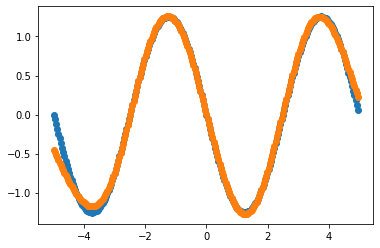

In [10]:
plt.scatter(x, u_true)
plt.scatter(x, learned_func1)
plt.show()

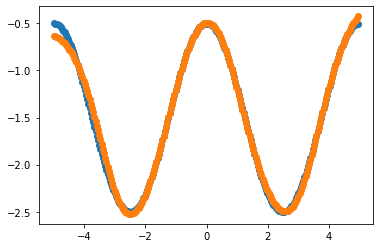

In [11]:
plt.scatter(x, u_x_true)
plt.scatter(x, learned_func2)
plt.show()

In [14]:
save(pinn, "parametric_pinn_with_fg.pth")

In [23]:
equations = pysr(
    x, learned_func1,
    populations=50, npop=2000, niterations=5,
    binary_operators=["+", "*"],
    unary_operators=["sin", "cos"],
)
# learned_func1: sin(-1.231026 * x0)
# learned_func2: cos(1.2608153*x0) - 1.5014627
# learned_func3: 0.09376708 (Constant)
print(best(equations))

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmpfroh__uh/runfile.jl
Activating environment on workers.
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 2.420e+03
Head worker occupation: 4.6%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           7.948e-01  -0.000e+00  -0.0039955135
3           6.555e-01  9.635e-02  (0.12929986 * x0)
4           3.

In [22]:
equations = pysr(
    x, learned_func2,
    populations=50, npop=2000, niterations=5,
    binary_operators=["+", "*"],
    unary_operators=["sin", "cos"],
)
print(best(equations))

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmp59pbn8cx/runfile.jl
Activating environment on workers.
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 1.820e+03
Head worker occupation: 3.8%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.900e-01  -0.000e+00  -1.4981421
4           2.741e-01  1.936e-01  (cos(x0) + -1.3023497)
6           